Dataset: https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop
# understanding information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
path = '../2019-Oct.csv'

In [143]:
writer = pd.ExcelWriter("1910data_summary.xlsx")

In [4]:
df = pd.read_csv(path)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     object        
 1   event_type     object        
 2   product_id     int64         
 3   category_id    int64         
 4   category_code  object        
 5   brand          object        
 6   price          float64       
 7   user_id        int64         
 8   user_session   object        
 9   time_zoneless  datetime64[ns]
 10  date           datetime64[ns]
 11  time           object        
 12  hour           int64         
 13  minute         int64         
 14  second         int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(6)
memory usage: 469.5+ MB


## transfer event_time to datetime
为后续按日期、小时处理数据，先将时间数据列转为datetime数据格式，并新增时分秒列

In [6]:
import re
#split date and time
df['time_zoneless'] = df.event_time.str[:-3]
df['date'] = df.time_zoneless.map(lambda x: re.compile(' ').split(x)[0])
df['time'] = df.time_zoneless.map(lambda x: re.compile(' ').split(x)[1])
df.time_zoneless = pd.to_datetime(df['time_zoneless'])
df.date = pd.to_datetime(df['date'])

In [7]:
df['hour'] = df.time_zoneless.dt.hour
df['minute'] = df.time_zoneless.dt.minute
df['second'] = df.time_zoneless.dt.second
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_zoneless,date,time,hour,minute,second
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00,2019-10-01,00:00:00,0,0,0
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03,2019-10-01,00:00:03,0,0,3
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07,2019-10-01,00:00:07,0,0,7
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07,2019-10-01,00:00:07,0,0,7
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15,2019-10-01,00:00:15,0,0,15


此处新增的无时区标记时间列、日期列为datetime格式；时分秒列为整数格式

# customer behavior analysis
## PV and UV
### daily for all events
Use group by to calculate the page view and unique visitor in each day:

In [8]:
pv_d = df.groupby('date').user_id.count().reset_index()
pv_d.rename(columns = {'user_id':'pv'}, inplace = True)
uv_d = df.groupby('date').user_id.nunique().reset_index()
uv_d.rename(columns = {'user_id':'uv'}, inplace = True)

In [16]:
pv_d['day'] = pv_d.date.dt.strftime("%d")
uv_d['day'] = uv_d.date.dt.strftime('%d')
pv_d.head()

,date,pv,day
0,2019-10-01,142414,01
1,2019-10-02,201068,02
2,2019-10-03,124847,03
3,2019-10-04,115612,04
4,2019-10-05,106343,05


In [144]:
pv_d.to_excel(writer, sheet_name="2.11dailyPV", index=False)
uv_d.to_excel(writer, sheet_name="2.11dailyUV", index=False)

### hourly for all events
Use groupby to extract PV and UV data in different hours.  
For the hour is set from 0 to 23, add one row for 24 and set the data in this row the same as the data from 0.

In [19]:
pv_hour = df.groupby('hour').user_id.count().reset_index().rename(columns = {'user_id':'pv'})
#增加24点的数据，与0点相同，使后边的折线图连贯到24点
pv_hour.loc['24'] = pv_hour.iloc[0,1]

In [20]:
uv_hour = df.groupby('hour').user_id.nunique().reset_index().rename(columns = {'user_id':'uv'})
uv_hour.loc['24'] = uv_hour.iloc[0,1]

In [145]:
pv_hour.to_excel(writer, sheet_name="2.12hourlyPV")
uv_hour.to_excel(writer, sheet_name="2.12hourlyUV")

### Daily for each event type
Extract PV and UV data for four different event types in every day:  
Using the groupby method or pivor table method:

In [22]:
#daily
pv_event = df.groupby(['event_type','date']).user_id.count().reset_index().rename(columns = {'user_id':"pv"})
uv_event = df.groupby(['event_type','date']).user_id.nunique().reset_index().rename(columns = {'user_id':"uv"})

In [163]:
#The previous one also can use .unstack() to transfer to pivot table, or using following code:
#pd.pivot_table(pv_event, values = 'pv', index = 'date', 
#               columns = 'event_type')

In [146]:
pv_event.to_excel(writer, sheet_name="2.13eventPV", index=False)
uv_event.to_excel(writer, sheet_name="2.13eventUV", index=False)

### Hourly for each event type

Extract hourly PV and UV data for different event types  
add four rows for 24th hour in each event type, which equals to the data in at 0 a.m.

In [24]:
#hourly
pv_event_h = df.groupby(['event_type','hour']).user_id.count().reset_index().rename(columns = {'user_id':'pv'})
uv_event_h = df.groupby(['event_type','hour']).user_id.nunique().reset_index().rename(columns = {'user_id':'uv'})

In [172]:
#set 24 = 0
pv_event_h.loc['96'] = ['cart',24,pv_event_h.iloc[0,2]]
pv_event_h.loc['97'] = ['purchase',24,pv_event_h.iloc[24,2]]
pv_event_h.loc['98'] = ['remove_from_cart',24,pv_event_h.iloc[48,2]]
pv_event_h.loc['99'] = ['view',24,pv_event_h.iloc[72,2]]
print(pv_event_h.tail())
uv_event_h.loc['96'] = ['cart',24,uv_event_h.iloc[0,2]]
uv_event_h.loc['97'] = ['purchase',24,uv_event_h.iloc[24,2]]
uv_event_h.loc['98'] = ['remove_from_cart',24,uv_event_h.iloc[48,2]]
uv_event_h.loc['99'] = ['view',24,uv_event_h.iloc[72,2]]
print(uv_event_h.tail())

          event_type  hour     pv
95              view    23  21929
96              cart    24  17080
97          purchase    24   2082
98  remove_from_cart    24   7110
99              view    24  16743
          event_type  hour    uv
95              view    23  7227
96              cart    24  3632
97          purchase    24   192
98  remove_from_cart    24   751
99              view    24  6522


In [147]:
pv_event_h.to_excel(writer, sheet_name="2.14eventhourlyPV", index=False)
uv_event_h.to_excel(writer, sheet_name="2.14eventhourlyUV", index=False)

## customer purchase behavior analysis
### customer buying frequency analysis
Calculate that how many times totally one user has purchased in this month.

In [149]:
daily_purchase_user = df[df.event_type == 'purchase'].groupby('user_id').event_type.count()

user_id
29025780     18
31229488      4
33535391     11
33609704      9
34080306      3
             ..
566264460     6
566270279     6
566270544     1
566272734     7
566274213     1
Name: event_type, Length: 25762, dtype: int64

In [154]:
daily_purchase_user.to_excel(writer, sheet_name="2.21buyfreq")

### Daily GMV

In [152]:
daily_revenue = df[df.event_type == 'purchase'].groupby('date').price.sum().reset_index()

In [153]:
daily_revenue.to_excel(writer, sheet_name="2.22dailyGMV", index=False)

### Daily ARPPU(average revenue per paying user)
Extract the total revenue for each day and the number of unique purchased users.  
Calculate the ARPPU = daily total revenue / daily total unique purchaser:

In [30]:
daily_revenue = df[df.event_type == 'purchase'].groupby('date').price.sum().reset_index()
daily_pay_user = df[df.event_type == 'purchase'].groupby('date').user_id.nunique().reset_index()

In [31]:
daily_arppu = pd.merge(daily_revenue,daily_pay_user, on = 'date')
daily_arppu.head()

,date,price,user_id
0,2019-10-01,43497.17,1001
1,2019-10-02,45746.20,1045
2,2019-10-03,43380.98,1048
3,2019-10-04,35887.15,892
4,2019-10-05,29228.55,708


In [32]:
daily_arppu['arppu'] = daily_arppu.price/daily_arppu.user_id
daily_arppu['day'] = daily_arppu.date.dt.strftime('%d')
daily_arppu.head()

,date,price,user_id,arppu,day
0,2019-10-01,43497.17,1001,43.453716,01
1,2019-10-02,45746.20,1045,43.776268,02
2,2019-10-03,43380.98,1048,41.394065,03
3,2019-10-04,35887.15,892,40.232231,04
4,2019-10-05,29228.55,708,41.283263,05


In [155]:
daily_arppu.to_excel(writer, sheet_name="2.23dailyARPPU", index=False)

### Daily ARPU(Average Revenue per user)
extract amount of daily actived users  
calculate ARPU = daily total revenue/daily actived users

In [34]:
daily_user = df.groupby('date').user_id.nunique().reset_index().rename(columns = {"user_id":"daily_active"})
daily_user.head()

,date,daily_active
0,2019-10-01,19230
1,2019-10-02,33859
2,2019-10-03,16323
3,2019-10-04,14732
4,2019-10-05,14990


In [35]:
daily_arpu = pd.merge(daily_revenue, daily_user, on = 'date')
daily_arpu['arpu'] = daily_arpu.price/daily_arpu.daily_active
daily_arpu['day'] = daily_arpu.date.dt.strftime('%d')
daily_arpu.arpu.describe()

count    31.000000
mean      2.239887
std       0.365562
min       1.054989
25%       2.144566
50%       2.290572
75%       2.455266
max       2.659999
Name: arpu, dtype: float64

In [157]:
daily_arpu.to_excel(writer, sheet_name="2.24dailyARPU", index=False)

### pay user rate
pay user rate = total paied user/total active user

In [37]:
daily_pay_user = df[df.event_type == 'purchase'].groupby('date').user_id.nunique().reset_index().rename(columns = {'user_id':'daily_pay_user'})

In [141]:
daily_pay_rate = daily_pay_user.daily_pay_user/daily_user.daily_active
daily_pay_rate.describe()

count    31.000000
mean      0.053604
std       0.008662
min       0.026528
25%       0.051794
50%       0.055876
75%       0.059352
max       0.064204
dtype: float64

In [159]:
daily_pay_rate.to_excel(writer, sheet_name="2.26payRate")

## Retention Rate
### all user retention

In [40]:
user_num = df.groupby("date")["user_id"].unique()
user_num.head()

date
2019-10-01    [463240011, 429681830, 430174032, 377667011, 4...
2019-10-02    [555815087, 555815138, 555815115, 555815140, 5...
2019-10-03    [538931315, 430209260, 418167791, 536189308, 2...
2019-10-04    [455300469, 509042489, 556530981, 556546665, 4...
2019-10-05    [417143062, 556829500, 464592812, 411689951, 5...
Name: user_id, dtype: object

In [160]:
user_num.to_excel(writer, sheet_name="2.31allUserRetentionOriginData")

### Compare retention rate between all users and purchased users

In [162]:
purchased = df[df.event_type == "purchase"]
user_num_purchased = purchased.groupby("date")["user_id"].unique()

In [163]:
user_num_purchased.to_excel(writer, sheet_name="2.32purUserRetentionOriginData")

## repurchase rate
### repurchase times
Extract purchase times for all purcased users: Use different user sessions to define a repurchase  

In [46]:
buy = df[df.event_type == 'purchase'].groupby(['user_id']).user_session.nunique().reset_index().rename(columns = {'user_session':'times'})
buy.head()

,user_id,times
0,29025780,1
1,31229488,1
2,33535391,1
3,33609704,1
4,34080306,1


Seperate the users who purchase more than once.  
calculate repurchase rate and draw histgram for repurchase times.

In [47]:
rebuy_amount = buy[buy.times >= 2]
rebuy_amount['re_times'] = rebuy_amount.times-1
rebuy_amount.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,times,re_times
25,69749548,2,1
45,92366748,2,1
47,95758554,3,2
70,121496884,2,1
81,140439288,2,1


In [61]:
rebuy_amount.re_times.describe()

count    2709.000000
mean        1.315615
std         1.034335
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        30.000000
Name: re_times, dtype: float64

Repurchase rate is 0.1052


(array([2.693e+03, 1.400e+01, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. ]),
 <a list of 5 Patch objects>)

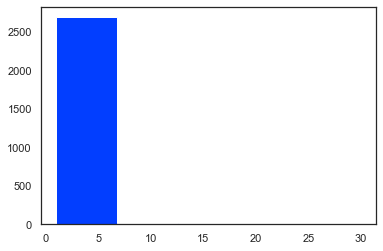

In [63]:
repurchase_rate = round(len(rebuy_amount)/len(buy),4)
print('Repurchase rate is {}'.format(repurchase_rate))
sns.set(style = 'white', palette = 'bright')
plt.hist(rebuy_amount.re_times, bins = 5)

For more than 75% of users only repurchase once, use pd.cut to seperate the repurchase time to 1, 2, 3 and more than 3 in order to draw pie chart.

In [48]:
bins_rebuy = [0,1,2,100]
labels_rebuy = ['once','twice',"more than twice"]
rebuy_amount['bins'] = pd.cut(rebuy_amount.re_times,bins = bins_rebuy, labels = labels_rebuy)
rebuy_amount.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,times,re_times,bins
25,69749548,2,1,once
45,92366748,2,1,once
47,95758554,3,2,twice
70,121496884,2,1,once
81,140439288,2,1,once


In [49]:
rebuy_bins_per = rebuy_amount.groupby('bins').user_id.count().reset_index()
rebuy_bins_per['per'] = rebuy_bins_per.user_id/rebuy_bins_per.user_id.sum()
rebuy_bins_per

,bins,user_id,per
0,once,2190,0.808416
1,twice,370,0.136582
2,more than twice,149,0.055002


In [164]:
rebuy_bins_per.to_excel(writer, sheet_name="2.41rebuyBin", index=False)

### repurchase time gap
Calculate the repurchase time gap between a user first purchase and the last purchse in this month.  
Extract the min and max purchase time from repurchase users.

In [51]:
def repur_gap_max(user_record_date):
    """求一个用户复购的最大日期间隔"""
    max_gap = user_record_date[1]-user_record_date[0]
    if len(user_record_date)>=3:
        for x in range(1, len(user_record_date)-1):
            date1 = user_record_date[x]
            date2 = user_record_date[x+1]
            gap = date2-date1
            if gap > max_gap:
                max_gap = gap
    return max_gap

In [52]:
purchase = df[df.event_type == 'purchase']
repur = purchase.groupby(['user_id']).user_session.count().reset_index()
repur_data = purchase[purchase.user_id.isin(repur[repur.user_session>=2].user_id)]
repur_time_gap = repur_data.groupby(['user_id']).date.apply(lambda x: x.max()-x.min())
repur_time_gap.head()

user_id
29025780   5 days
31229488   0 days
33535391   0 days
33609704   0 days
34080306   0 days
Name: date, dtype: timedelta64[ns]

In [53]:
repur_time_gap = repur_time_gap.reset_index()
repur_time_gap.head()

,user_id,date
0,29025780,5 days
1,31229488,0 days
2,33535391,0 days
3,33609704,0 days
4,34080306,0 days


In [54]:
repur_time_gap.date = repur_time_gap.date.dt.days

In [55]:
repur_time_gap.date.describe()

count    23324.000000
mean         1.246441
std          4.405746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: date, dtype: float64

Repurchase is defined as user who purchase on different days, so the time gap zero day is removed.

In [56]:
timegap_nosameday = repur_time_gap.date[repur_time_gap.date > 0]
timegap_nosameday.describe()

count    2492.000000
mean       11.666132
std         7.754571
min         1.000000
25%         5.000000
50%        11.000000
75%        18.000000
max        30.000000
Name: date, dtype: float64

In [166]:
timegap_nosameday.to_excel(writer, sheet_name="2.42rebuyTimeGap")

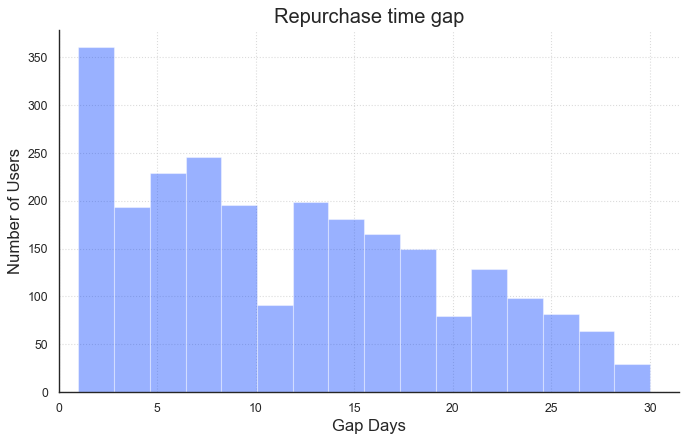

In [72]:
fig = plt.figure(figsize = (10,6), dpi = 80)
ax = fig.add_subplot()
sns.set(style = 'white', palette = 'bright')
sns.distplot(timegap_nosameday, bins = 16,kde = False, color = 'b')
plt.xlim(xmin = 0)
plt.title('Repurchase time gap',fontsize = 18)
plt.xlabel('Gap Days', fontsize = 15)
plt.grid(linestyle = ':', alpha = 0.7)
plt.ylabel('Number of Users', size = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xticks(range(1,31,2))
#plt.savefig('2.32 Repurchase time gap.png')

有复购行为的用户，除当天、第二天就进行再次购买外，其他在本月购买行为的最大时间间隔比较均匀的分部在2到30天。

## single user payment in total

In [142]:
single_pay = purchase.groupby("user_id").price.sum()
single_pay.describe()

user_id
29025780      41.68
31229488      14.43
33535391     138.88
33609704      31.31
34080306      16.75
              ...  
566264460      9.74
566270279     32.74
566270544     19.84
566272734     10.79
566274213     21.59
Name: price, Length: 25762, dtype: float64

In [167]:
single_pay.to_excel(writer, sheet_name="2.5singlePay")

# 制作漏斗图 calculate funnel

## split and merge four phases data
定义一个转化路径为同一个用户对同一个商品，从浏览到加购到下单，或从浏览到加购到移除购物车。  
The data is splited based on four event types. Then, the data from four phases is merged on the same user id and the same product id, which can be used to understand whether the same user do the next phase event for the same product.  
Also, for the data only includes the event history in October, some events may links to the previous history. For instance, a product may be added to cart in September and remove from cart in October. This type of data is excluded in the conversion rate analysis. 

In [60]:
df_view = df[df.event_type == 'view']
df_cart = df[df.event_type == 'cart']
df_rf_cart = df[df.event_type == 'remove_from_cart']
df_purchase = df[df.event_type == 'purchase']

### view to cart

In [61]:
df_v_to_c = pd.merge(left = df_view[['time',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_cart[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_view','_cart'])

In [62]:
df_v_to_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166987 entries, 0 to 2166986
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   product_id     int64  
 2   user_id        int64  
 3   brand          object 
 4   price          float64
 5   category_id    int64  
 6   category_code  object 
 7   time_cart      object 
dtypes: float64(1), int64(3), object(4)
memory usage: 148.8+ MB


In [63]:
df_v_to_c.head()

,time_view,product_id,user_id,brand,price,category_id,category_code,time_cart
0,00:00:26,5875317,474232307,NaN,1.59,2029082628195353599,NaN,00:01:13
1,00:00:28,5692917,555446068,lianail,5.54,1487580004857414477,NaN,NaN
2,00:00:48,5819638,546705258,NaN,21.75,1487580008162526182,NaN,NaN
3,00:00:53,5856191,507355498,runail,24.44,1487580006350586771,appliances.environment.vacuum,NaN
4,00:01:11,5733176,543446752,NaN,0.60,1487580009362096156,NaN,NaN


### cart to remove from cart

In [64]:
df_v_c_r = pd.merge(left = df_v_to_c[['time_view','time_cart',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_rf_cart[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_cart','_rf_cart'])
df_v_c_r.rename(columns = {'time':'time_rf_cart'},inplace = True)
df_v_c_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811578 entries, 0 to 2811577
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   time_cart      object 
 2   product_id     int64  
 3   user_id        int64  
 4   brand          object 
 5   price          float64
 6   category_id    int64  
 7   category_code  object 
 8   time_rf_cart   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 214.5+ MB


### cart to buy

In [65]:
df_v_c_b = pd.merge(left = df_v_to_c[['time_view','time_cart',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_purchase[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_cart','_rf_cart'])
df_v_c_b.rename(columns = {'time':'time_purchase'},inplace = True)
df_v_c_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188536 entries, 0 to 2188535
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   time_cart      object 
 2   product_id     int64  
 3   user_id        int64  
 4   brand          object 
 5   price          float64
 6   category_id    int64  
 7   category_code  object 
 8   time_purchase  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 167.0+ MB


## funnel data calculate

In [66]:
df_v_to_c1 = df_v_to_c.groupby(['user_id','product_id']).time_cart.nunique().reset_index()
df_v_to_c1.head()

,user_id,product_id,time_cart
0,4103071,5563536,0
1,4103071,5670334,0
2,4103071,5735272,0
3,4103071,5784982,0
4,4103071,5795273,0


In [67]:
view_num = len(df_v_to_c1)
cart_num = view_num - len(df_v_to_c1[df_v_to_c1.time_cart == 0])
v_to_c_rate = round(cart_num/view_num,4)
print("number of view users: {}, number of add cart users:{},v_to_c rate is {}".format(view_num, cart_num, v_to_c_rate))

number of view users: 1402922, number of add cart users:326246,v_to_c rate is 0.2325


In [68]:
df_c_to_r1 = df_v_c_r.groupby(['user_id','product_id']).time_rf_cart.nunique().reset_index()
df_c_to_r1.head()

,user_id,product_id,time_rf_cart
0,4103071,5563536,0
1,4103071,5670334,0
2,4103071,5735272,0
3,4103071,5784982,0
4,4103071,5795273,0


In [69]:
rf_num = len(df_c_to_r1[df_c_to_r1.time_rf_cart != 0])
rf_num
c_to_rf_rate = round(rf_num/cart_num,4)

In [70]:
df_v_c_b1 = df_v_c_b.groupby(['product_id','user_id']).time_purchase.nunique().reset_index()
df_v_c_b1.head()

,product_id,user_id,time_purchase
0,3752,306131139,0
1,3752,525448973,0
2,3752,543825317,0
3,3752,552966434,0
4,3752,558771491,0


In [71]:
b_num = len(df_v_c_b1[df_v_c_b1.time_purchase != 0])
b_num
c_to_b_rate = round(b_num/cart_num,4)

In [72]:
print("""
number of view is:{}
number of add to cart is :{}
number of remove from cart is:{}
number of purchase is :{}
rate from view to add to cart is:{:.2%}
rate from add to cart to remove is:{:.2%}
rate from add to cart to purchase is: {:.2%}
""".format(view_num, cart_num, rf_num, b_num,v_to_c_rate,c_to_rf_rate, c_to_b_rate))


number of view is:1402922
number of add to cart is :326246
number of remove from cart is:151954
number of purchase is :86771
rate from view to add to cart is:23.25%
rate from add to cart to remove is:46.58%
rate from add to cart to purchase is: 26.60%



In [81]:
funnel_data = {"view_num": view_num, "cart_num":cart_num, "rf_num":rf_num, "pur_num":b_num,
              "v_to_c": v_to_c_rate, "c_to_rf":c_to_rf_rate, "c_to_b":c_to_b_rate}
funnel_data = pd.DataFrame(funnel_data, index=["1910"])
funnel_data

,view_num,cart_num,rf_num,pur_num,v_to_c,c_to_rf,c_to_b
1910,1402922,326246,151954,86771,0.2325,0.4658,0.266


In [168]:
funnel_data.to_excel(writer, sheet_name="3funnelData")

# product category analysis

In [83]:
brandtop10 = df.brand.value_counts()[:10]
brandtop10 = brandtop10.reset_index().rename(columns = {"index":"top_brand","brand":"count"})
brandtop10.head()

,top_brand,count
0,runail,306239
1,irisk,226589
2,masura,195170
3,grattol,132130
4,bpw.style,114192


In [84]:
brand_event = df[df.brand.isin(brandtop10.top_brand)].groupby(['brand','event_type']).user_id.count().unstack().reset_index()

In [85]:
brand_event.head()

event_type,brand,cart,purchase,remove_from_cart,view
0,bpw.style,37785,9506,23576,43325
1,estel,16207,3211,8035,36989
2,grattol,33494,6438,24327,67871
3,ingarden,27948,5181,22060,35091
4,irisk,78293,15645,47330,85321


In [86]:
brand_event['v_to_c'] = brand_event.cart/brand_event.view
brand_event['c_to_b'] = brand_event.purchase/brand_event.cart
brand_event

event_type,brand,cart,purchase,remove_from_cart,view,v_to_c,c_to_b
0,bpw.style,37785,9506,23576,43325,0.872129,0.251581
1,estel,16207,3211,8035,36989,0.438157,0.198124
2,grattol,33494,6438,24327,67871,0.493495,0.192214
3,ingarden,27948,5181,22060,35091,0.796444,0.185380
4,irisk,78293,15645,47330,85321,0.917629,0.199826
5,kapous,14576,3117,7306,32916,0.442824,0.213845
6,masura,58657,11356,45649,79508,0.737750,0.193600
7,pole,19789,3360,15048,23408,0.845395,0.169791
8,runail,98737,21936,65957,119609,0.825498,0.222166
9,uno,13307,3218,8169,23334,0.570284,0.241828


In [87]:
brand_event_vb = brand_event.sort_values(by = 'v_to_c', ascending = False)

In [169]:
brand_event_vb.to_excel(writer, sheet_name="4brand", index=False)

# 20:80
## top 20 user

In [78]:
total_revenue = purchase.price.sum()
total_revenue

196408.74

In [79]:
top_user = purchase.groupby('user_id').price.sum().reset_index().sort_values(by = 'price', ascending = False)
per20 = int(len(top_user)*0.2)
top_20user_revenue = top_user.price[:per20].sum()
print('Revenue from top 20 users is {} percent'.format(round(top_20user_revenue/total_revenue, 2)))

Revenue from top 20 users is 0.52 percent


## top20 product

In [80]:
top_product = purchase.groupby('category_id').price.sum().reset_index().sort_values(by = 'price',ascending = False)
per20_category = int(len(top_product)*0.2)
top_20product_revenue = top_product.price[:per20_category].sum()
print('Revenue from top 20 categories is {} percent'.format(round(top_20product_revenue/total_revenue, 2)))

Revenue from top 20 categories is 0.81 percent


# RFM(recency, frequency, monetary)
## extract RFM data
calculate the purchased users' recent purchase time, purchase frequency in this month and the total payment they made.

In [89]:
purchase = df[df.event_type == 'purchase']
recent_buy_time = purchase.groupby('user_id').time_zoneless.max().reset_index().rename(columns = {'time_zoneless':'recent_pur_time'})

In [90]:
from datetime import datetime, timedelta
end_oct = datetime(2019,10,31,23,59,59)
recent_buy_time['gap'] = end_oct - recent_buy_time.recent_pur_time
recent_buy_time.gap = recent_buy_time.gap.map(lambda x:x.days)
recent_buy_time.head()

,user_id,recent_pur_time,gap
0,29025780,2019-10-07 17:57:48,24
1,31229488,2019-10-03 12:24:58,28
2,33535391,2019-10-13 19:07:28,18
3,33609704,2019-10-15 07:55:05,16
4,34080306,2019-10-30 18:30:12,1


In [91]:
buy_freq = purchase.groupby('user_id').time_zoneless.count().reset_index().rename(columns = {'time_zoneless':'pur_freq'})
buy_freq.head()

,user_id,pur_freq
0,29025780,18
1,31229488,4
2,33535391,11
3,33609704,9
4,34080306,3


In [92]:
monetary = purchase.groupby('user_id').price.sum().reset_index().rename(columns = {'price':'total_momentary'})
monetary.head()

,user_id,total_momentary
0,29025780,41.68
1,31229488,14.43
2,33535391,138.88
3,33609704,31.31
4,34080306,16.75


In [93]:
rfm_data = pd.merge(recent_buy_time, buy_freq, on = 'user_id')

In [94]:
rfm_data = pd.merge(rfm_data, monetary, on = 'user_id')

In [95]:
rfm_data.head()

,user_id,recent_pur_time,gap,pur_freq,total_momentary
0,29025780,2019-10-07 17:57:48,24,18,41.68
1,31229488,2019-10-03 12:24:58,28,4,14.43
2,33535391,2019-10-13 19:07:28,18,11,138.88
3,33609704,2019-10-15 07:55:05,16,9,31.31
4,34080306,2019-10-30 18:30:12,1,3,16.75


In [170]:
rfm_data.to_excel(writer, sheet_name="6RFMscore", index=False)

In [171]:
writer.save()
writer.close()